# **Example 04: Unrolled network on complex-valued data with complex-valued operations**
We first define the data pipelines to feed the data into training, validation and test set. The MNIST database is used for showcasing. Since MNIST are real-valued images, a phase is simulated and added to the images to generate a complex-valued input. The fourier transformed image serves as k-space for data consistency. Single-MR-coil processing is performed. A retrospective undersampling according to a Parallel Imaging (PI) or Compressed Sensing (CS) like trajectory is simulated and applied to the data. The task of the network is to reconstruct the undersampled data with complex-valued operations.

To enable GPU support in Google Colab, please go to `Edit -> Notebook settings` and select `GPU` as hardware accelerator.

In [1]:
# inspect the available GPU hardware
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission denied
Thu Nov  4 19:32:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:01:00.0 Off |                  Off |
| 33%   39C    P0    34W / 260W |    967MiB / 48593MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
            

## Database pipeline
Here starts the main part of the script. First define the data pipelines (in the form of generator functions) for training, validation and test set. Retrospective undersampling is performed inside the generator functions.

In [2]:
import tensorflow as tf
import numpy as np
import os
import datetime
import tutorial
import merlintf

# initialize some parameters
accelerations = [2, 4]  # simulate retrospectively accelerations in the range of e.g. 2x to 4x
accel_type = 'PI'  # simulated undersampling strategy: 'PI' = Parallel Imaging, 'CS' = Compressed Sensing
center = 0.1  # percent of fully sampled central region along ky phase-encoding, e.g. 0.1 := floor(10% * 28) ky center lines = 2 ky center lines 

# Data Generators (Data pipeline) for complex-valued data with k-space
# training set
training_generator = tutorial.datasets.ComplexRawDataGeneratorMNIST(batch_size=32, 
                                    accelerations=accelerations,
                                    accel_type=accel_type,
                                    center=center, 
                                    shuffle=True,
                                    mode='train')

# validation set
validation_generator = tutorial.datasets.ComplexRawDataGeneratorMNIST(batch_size=32, 
                                    accelerations=accelerations,
                                    accel_type=accel_type,
                                    center=center,
                                    shuffle=False,
                                    mode='val')

# test set
# ideally testing should be performed on prospectively accelerated acquisitions
test_generator = tutorial.datasets.ComplexRawDataGeneratorMNIST(batch_size=1, 
                                    accelerations=accelerations,
                                    accel_type=accel_type,
                                    center=center,
                                    shuffle=False,
                                    mode='test')

print('Training batches to process:', len(training_generator))
print('Validation batches to process:', len(validation_generator))
print('Test samples to process:', len(test_generator))

Training batches to process: 1500
Validation batches to process: 375
Test samples to process: 10000


## Model
Define the CNN model as an unrolled network with intermittant data consistency blocks.

### 3-layer (residual) convolutional neural network (CNN) denoising regularizer

In [3]:
# Define denoiser model
class Denoiser(tf.keras.Model):
    # initialize the required layers
    def __init__(self, filters, kernel_size=(3,3), strides=(1,1), use_bias=True, activation=None, is_residual=False, name='denoiser'):
        super().__init__(name=name)
        self.is_residual = is_residual
        self.conv_out1 = merlintf.keras.layers.ComplexConv2D(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding='SAME',
                                use_bias=use_bias,
                                activation=activation)

        self.conv_out2 = merlintf.keras.layers.ComplexConv2D(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding='SAME',
                                use_bias=use_bias,
                                activation=activation)

        self.conv_out3 = merlintf.keras.layers.ComplexConv2D(filters=1,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding='SAME',
                                use_bias=True,
                                activation=None)
        
    def call(self, inputs):
        x = self.conv_out1(inputs)
        x = self.conv_out2(x)
        x = self.conv_out3(x)
        if self.is_residual:
            x = tf.keras.layers.Add()([inputs, x])
        return x


### Unrolled reconstruction network
Combine denoising regularizer and data consistency blocks to an unrolled reconstruction network

In [4]:
# Define unrolled reconstruction model
class UnrolledNetwork(tf.keras.Model):
    # initialize the required layers
    def __init__(self, cascades, shared_params=True, is_residual=True, activation='ModReLU', name=None):
        super().__init__(name=name)

        self.T = 1 if shared_params else cascades  # shared denoiser network or (new) cascaded denoisers
        self.T_end = cascades  # number of cascades

        self.denoiser = [Denoiser(filters=4, is_residual=is_residual, activation=activation) for _ in range(self.T)]  # prepare denoising networks

        A = merlintf.keras.layers.ForwardOp(center=True)
        AH = merlintf.keras.layers.AdjointOp(center=True)

        self.dc = [merlintf.keras.layers.DCGD(A, AH, weight_init=1.0, max_iter=10) for _ in range(self.T)]  # prepare data consistency blocks

    # build the model in the forward path
    def call(self, inputs):
        x = inputs[0]                                       # undersampled image
        for i in range(self.T_end):                         # unrolled network
            ii = i % self.T
            x = self.denoiser[ii](x)                    # denoising regularizer
            x = self.dc[ii]([x,] + list(inputs[1:]))    # data consistency
        return x
    
# instantiate a keras model as sub-class model
# define network with model subclassing to control forward/backward path, training procedure, etc.
model = UnrolledNetwork(cascades=5)
# make one forward pass to initalize model
inputs, _ = training_generator.__getitem__(0)
output = model(inputs)

# print model overview
print(model.summary())

Model: "unrolled_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
denoiser (Denoiser)          multiple                  458       
_________________________________________________________________
dcgd (DCGD)                  multiple                  1         
Total params: 459
Trainable params: 459
Non-trainable params: 0
_________________________________________________________________
None


### Build model
Compile the model, assign an optimizer, loss function and validation metrics. Prepare some keras callbacks to monitor training progress.

In [5]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),      # used optimizer with chosen learning rate
              loss='mse',                                                   # loss function 
              metrics=['mse', 'mae'])                                       # evaluation metrics (for training and validation set)

# define callbacks to monitor model
keras_callbacks = tutorial.get_callbacks(validation_generator, model)

## Tensorboard
Start the Tensorboard [optional] to monitor training progress and display validation outputs.

In [6]:
# start Tensorboard
%load_ext tensorboard
%tensorboard --logdir=logs

## Training
Train the configured and compiled model. Monitor training progress with validation set.

In [7]:
# train model with training set and evaluate its performance with the validation set
model.fit(training_generator,                       # training set
          validation_data=validation_generator,     # validation set
          epochs=5,                                 # number of epochs to train the model
          callbacks=keras_callbacks)                # callbacks to monitor or control training

Epoch 1/3
1500/1500 [==============================] - 73s 46ms/step - loss: 0.2319 - mse: 0.1332 - mae: 0.1849 - val_loss: 0.0555 - val_mse: 0.0445 - val_mae: 0.1333
Epoch 2/3
1500/1500 [==============================] - 67s 45ms/step - loss: 0.0542 - mse: 0.0429 - mae: 0.1300 - val_loss: 0.0475 - val_mse: 0.0370 - val_mae: 0.1167
Epoch 3/3
1500/1500 [==============================] - 67s 45ms/step - loss: 0.0604 - mse: 0.0441 - mae: 0.1272 - val_loss: 0.0565 - val_mse: 0.0433 - val_mae: 0.1422


## Testing
Test the trained model to predict a denoised output and to display performance (metrics) on test set.

In [8]:
# predict with trained model
predicted_output = model.predict(test_generator)

# evaluate trained model
loss_metric_test = model.evaluate(test_generator)

10000/10000 [==============================] - 171s 17ms/step - loss: 0.0577 - mse: 0.0444 - mae: 0.1440


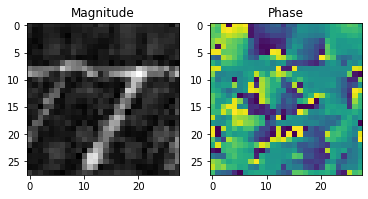

In [9]:
# display the predicted output
import matplotlib.pyplot as plt
icase = 0  # display the first example
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.squeeze(np.abs(predicted_output[icase,])), cmap='gray')
plt.title('Magnitude')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(np.angle(predicted_output[icase,])))
plt.title('Phase')
plt.show()